In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import *
%load_ext autoreload
%autoreload 3
import warnings
warnings.filterwarnings("ignore")

In [2]:
from helpers.collection_of_experiments import *

In [3]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [4]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR, operator=gaussian_remesh, FGR=np.sqrt(6), exp=f'R64_{RR}_FGR-sqrt6')

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2_FGR-sqrt6
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3_FGR-sqrt6
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR-sqrt6
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5_FGR-sqrt6
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6_FGR-sqrt6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7_FGR-sqrt6
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8_FGR-sqrt6


In [5]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    for file in [f'/scratch/pp2681/Yellowstone/filtered-data/R64_{RR}_FGR-sqrt6-part1.nc', 
                 f'/scratch/pp2681/Yellowstone/filtered-data/R64_{RR}_FGR-sqrt6-part2.nc',
                 f'/scratch/pp2681/Yellowstone/filtered-data/R64_{RR}_FGR-sqrt6-part3.nc']:
            dataset = xr.open_dataset(file, decode_times=False)
            for key in dataset.keys():
                var = dataset[key]
                var['Time'] = ds['R64'].u['Time']
                setattr(ds[f'R64_{RR}_FGR-sqrt6'], key, var)

In [6]:
RR = 'R8'
exp = ds[f'R64_{RR}_FGR-sqrt6']
SGS_transfer = exp.transfer(exp.SGSx, exp.SGSy)
SGS_CA_transfer = exp.transfer(exp.SGS_CAu, exp.SGS_CAv)

In [7]:
# Dynamic models in the same square as SGS transfer
DbMM_Reynolds_no_clip = exp.dynamic_model(ssm=True, reynolds=True, clip=False, SGS_CAu = exp.SGS_CAu, SGS_CAv = exp.SGS_CAv)
DbMM_Reynolds_clip = exp.dynamic_model(ssm=True, reynolds=True, clip=True)

DbMM_Reynolds_no_clip_SSD = exp.dynamic_model_SSD(ssm=True, reynolds=True, clip=False)
DbMM_Reynolds_clip_SSD = exp.dynamic_model_SSD(ssm=True, reynolds=True, clip=True)

In [8]:
SGS_dict = {}
for key in ['DbMM_Reynolds_no_clip', 'DbMM_Reynolds_clip', 'DbMM_Reynolds_no_clip_SSD', 'DbMM_Reynolds_clip_SSD']:
    %time SGS_dict[key] = exp.transfer(eval(key)['dudt'], eval(key)['dvdt']).compute()

CPU times: user 1min 15s, sys: 30 s, total: 1min 45s
Wall time: 14.6 s
CPU times: user 1min 19s, sys: 30.7 s, total: 1min 50s
Wall time: 14.1 s
CPU times: user 47.2 s, sys: 24.4 s, total: 1min 11s
Wall time: 11.4 s
CPU times: user 49.3 s, sys: 24.4 s, total: 1min 13s
Wall time: 10.7 s


In [9]:
%time SGS_dict['optimal'] = exp.transfer(DbMM_Reynolds_no_clip['dudt_opt'], DbMM_Reynolds_no_clip['dvdt_opt']).compute()

CPU times: user 19.8 s, sys: 14.3 s, total: 34 s
Wall time: 7.17 s


In [10]:
Cs = {}
CR = {}
for key in ['DbMM_Reynolds_no_clip', 'DbMM_Reynolds_clip', 'DbMM_Reynolds_no_clip_SSD', 'DbMM_Reynolds_clip_SSD']:
    %time Cs[key] = eval(key)['Cs'].compute()
    %time CR[key] = eval(key)['CR'].compute()

CPU times: user 30.3 s, sys: 9.08 s, total: 39.4 s
Wall time: 4.9 s
CPU times: user 1min 11s, sys: 20.1 s, total: 1min 31s
Wall time: 10 s
CPU times: user 30.1 s, sys: 9.01 s, total: 39.1 s
Wall time: 4.89 s
CPU times: user 1min 9s, sys: 19.8 s, total: 1min 29s
Wall time: 10.1 s
CPU times: user 15.2 s, sys: 5.34 s, total: 20.6 s
Wall time: 2.93 s
CPU times: user 29 s, sys: 9.49 s, total: 38.5 s
Wall time: 4.97 s
CPU times: user 16.2 s, sys: 5.66 s, total: 21.9 s
Wall time: 3.12 s
CPU times: user 30.7 s, sys: 9.93 s, total: 40.6 s
Wall time: 5.21 s


In [11]:
%time Cs['optimal'] = DbMM_Reynolds_no_clip['Cs_opt'].compute()
%time CR['optimal'] = DbMM_Reynolds_no_clip['CR_opt'].compute()

CPU times: user 15 s, sys: 5.1 s, total: 20.1 s
Wall time: 3.17 s
CPU times: user 14.4 s, sys: 4.93 s, total: 19.3 s
Wall time: 3.07 s


In [12]:
def Cs_string(key, zl=0, Averaging_time = slice(3650,7300)):
    series = Cs[key].isel(zl=zl).sel(Time=Averaging_time)
    mean = float(series.mean())
    std = float(series.std())
    #return "$C_S=%.3f\pm%.3f$" % (mean ,std)
    return "$C_S=%.3f$" % (mean)

def CR_string(key, zl=0, Averaging_time = slice(3650,7300)):
    series = CR[key].isel(zl=zl).sel(Time=Averaging_time)
    mean = float(series.mean())
    std = float(series.std())
    #return "$C_R=%.1f\pm%.1f$" % (mean ,std)
    return "$C_R=%.1f$" % (mean)

Text(0.5, 1.1, 'Germano identity dynamic models a priori at $1/8|^\\circ$')

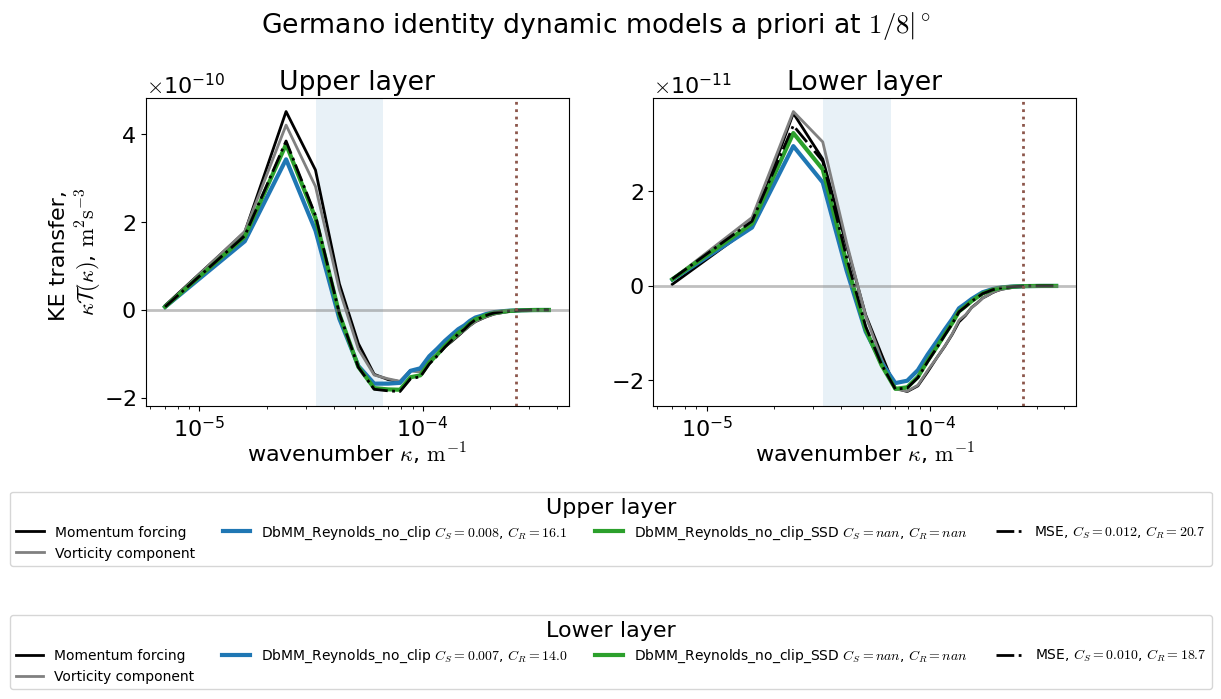

In [14]:
def compensated(sp):
    return sp * sp.freq_r

default_rcParams({'font.size':16, 'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.15})
zl=0
fig = plt.figure(figsize=(12,4))

colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]

for zl in [0,1]:
    plt.subplot(1,2,1+zl)
    compensated(SGS_transfer).isel(zl=zl).plot(color='k', lw=2, label='Momentum forcing')
    compensated(SGS_CA_transfer).isel(zl=zl).plot(color='gray', lw=2, label='Vorticity component')
    compensated(SGS_dict['DbMM_Reynolds_no_clip']).isel(zl=zl).plot(lw=3, ls = '-', color=colors[0],
                    label='DbMM_Reynolds_no_clip %s, %s' % (Cs_string('DbMM_Reynolds_no_clip',zl=zl), CR_string('DbMM_Reynolds_no_clip',zl=zl)))
    #compensated(SGS_dict['DbMM_Reynolds_clip']).isel(zl=zl).plot(lw=2, ls = '-.', color=colors[0],
    #                label='DbMM_Reynolds_clip %s, %s' % (Cs_string('DbMM_Reynolds_clip',zl=zl), CR_string('DbMM_Reynolds_clip',zl=zl)))

    compensated(SGS_dict['DbMM_Reynolds_no_clip_SSD']).isel(zl=zl).plot(lw=3, ls = '-', color=colors[2],
                    label='DbMM_Reynolds_no_clip_SSD %s, %s' % (Cs_string('DbMM_Reynolds_no_clip_SSD',zl=zl), CR_string('DbMM_Reynolds_no_clip_SSD',zl=zl)))
    #compensated(SGS_dict['DbMM_Reynolds_clip_SSD']).isel(zl=zl).plot(lw=2, ls = '--', color=colors[3],
    #                label='DbMM_Reynolds_clip_SSD %s, %s' % (Cs_string('DbMM_Reynolds_clip_SSD',zl=zl), CR_string('DbMM_Reynolds_clip_SSD',zl=zl)))    
    
    compensated(SGS_dict['optimal']).isel(zl=zl).plot(lw=2, ls = '-.', color='k', 
                label='MSE, %s, %s' % (Cs_string('optimal',zl=zl), CR_string('optimal',zl=zl)))


    plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
    Rd1 = 30000
    Rd2 = 15000
    plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
    plt.xscale('log')
    plt.xlabel('')
    dx = len(ds['R64'].h.xh) / len(exp.h.xh) * 1500 # in metres
    plt.xlim([None, 4.5e-4])
    #plt.xticks([1e-5, 1e-4, 1e-3])
    plt.xlabel('wavenumber $\kappa$, $\mathrm{m}^{-1}$')


    if zl==0:
        plt.ylabel('KE transfer, \n$\kappa \mathcal{T}(\kappa)$, $\mathrm{m}^2\mathrm{s}^{-3}$')
        plt.title('Upper layer')
        #plt.ylim([-0.5e-9,0.5e-9])
        #plt.yticks(np.linspace(-1e-9,1e-9,5))
        plt.axvline(x=np.pi/dx, ls=':', color='tab:brown', lw=2)
    else:
        #plt.ylim([-0.5e-10,0.5e-10])
        #plt.yticks(np.linspace(-1e-10,1e-10,5))
        plt.axvline(x=np.pi/dx, ymin=0.0, ls=':', color='tab:brown', lw=2)
        plt.title('Lower layer')
        #plt.text(3.3e-5,-1.2e-10,'Deformation \n     radius \n  $15-30$ km', fontsize=12, color='tab:blue')
        #plt.text(np.pi/dx, -1.2e-10, 'Grid scale\n   $\\pi/\\Delta x$', fontsize=12, color='tab:brown')

    if zl==0:
        plt.legend(bbox_to_anchor=(1.1,-0.4), loc='center', ncol=4, fontsize=10, title='Upper layer')
    else:
        plt.legend(bbox_to_anchor=(-0.1,-0.8), loc='center', ncol=4, fontsize=10, title='Lower layer')
plt.suptitle('Germano identity dynamic models a priori at $1/8|^\circ$', y=1.1)
#plt.savefig('figures/dyn_procedures_R2.pdf')

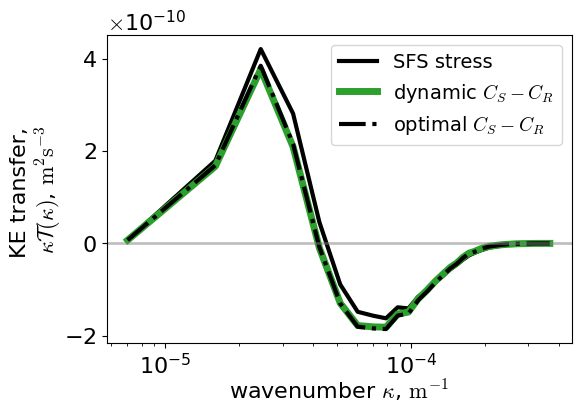

In [42]:
def compensated(sp):
    return sp * sp.freq_r

default_rcParams({'font.size':16, 'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.15})
zl=0
fig = plt.figure(figsize=(6,4))

colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]

for zl in [0]:
    compensated(SGS_CA_transfer).isel(zl=zl).plot(color='k', lw=3, label='SFS stress')
    compensated(SGS_dict['DbMM_Reynolds_no_clip_SSD']).isel(zl=zl).plot(lw=5, ls = '-', color=colors[2], label='dynamic $C_S-C_R$')
    compensated(SGS_dict['optimal']).isel(zl=zl).plot(lw=3, ls = '-.', color='k', label='optimal $C_S-C_R$')


    plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
    # Rd1 = 30000
    # Rd2 = 15000
    # plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
    plt.xscale('log')
    plt.xlabel('')
    dx = len(ds['R64'].h.xh) / len(exp.h.xh) * 1500 # in metres
    plt.xlim([None, 4.5e-4])
    plt.xlabel('wavenumber $\kappa$, $\mathrm{m}^{-1}$')
    
    plt.ylabel('KE transfer, \n$\kappa \mathcal{T}(\kappa)$, $\mathrm{m}^2\mathrm{s}^{-3}$')
    plt.title('')
    #plt.axvline(x=np.pi/dx, ls=':', color='tab:brown', lw=2)
    plt.legend(fontsize=14)
    plt.savefig('figures_m2lines/transfer.pdf')